In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from utilities import preprocessing
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions
from pyspark.sql.functions import col, udf
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
spark = SparkSession.builder \
           .appName('Tuning Text Classification Model') \
           .config("spark.jars", "mysql-connector-j-8.0.32.jar")\
           .config("spark.driver.memory", "6g") \
           .config("spark.executor.memory", "8g") \
           .getOrCreate()

In [3]:
text_classification_data = spark.read \
                                .format("jdbc") \
                                .option("driver","com.mysql.cj.jdbc.Driver") \
                                .option("url", "jdbc:mysql://web-database/Web") \
                                .option("dbtable", "textClassification") \
                                .option("user", "root") \
                                .option("password", "123") \
                                .load()

In [4]:
text_classification_data.show(10)

+-----+--------+--------------------+
|tagId|category|        descriptions|
+-----+--------+--------------------+
|    1|  Sports| David Eckstein p...|
|    2|  Sports|The Oakland Raide...|
|    3|  Sports| Tennessee quarte...|
|    4|  Sports| New Orleans Horn...|
|    5|  Sports| Los Angeles inve...|
|    6|  Sports|Wyatt Sexton will...|
|    7|   World|" The Nigerian re...|
|    8|   World|Pop producer Phil...|
|    9|Business|Unions representi...|
|   10|   World|The Senate opened...|
+-----+--------+--------------------+
only showing top 10 rows



In [5]:
text_classification_data = text_classification_data.select('category', 'descriptions')
text_classification_data = text_classification_data.dropna(subset = ('category'))

In [6]:
preprocessed_df = preprocessing(text_classification_data, 'descriptions')

In [7]:
preprocessed_df.show(5)

+--------+--------------------+--------------------+--------------------+
|category|        descriptions|  descriptions_words|            filtered|
+--------+--------------------+--------------------+--------------------+
|  Sports|David Eckstein pr...|[david, eckstein,...|[david, eckstein,...|
|  Sports|The Oakland Raide...|[the, oakland, ra...|[oakland, raiders...|
|  Sports|Tennessee quarter...|[tennessee, quart...|[tennessee, quart...|
|  Sports|New Orleans Horne...|[new, orleans, ho...|[new, orleans, ho...|
|  Sports|Los Angeles inves...|[los, angeles, in...|[los, angeles, in...|
+--------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [8]:
hashing_tf = HashingTF(inputCol = "filtered", outputCol = "raw_features")
featurized_data = hashing_tf.transform(preprocessed_df)

In [9]:
featurized_data.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+
|category|        descriptions|  descriptions_words|            filtered|        raw_features|
+--------+--------------------+--------------------+--------------------+--------------------+
|  Sports|David Eckstein pr...|[david, eckstein,...|[david, eckstein,...|(262144,[9708,187...|
|  Sports|The Oakland Raide...|[the, oakland, ra...|[oakland, raiders...|(262144,[13503,51...|
|  Sports|Tennessee quarter...|[tennessee, quart...|[tennessee, quart...|(262144,[14376,28...|
|  Sports|New Orleans Horne...|[new, orleans, ho...|[new, orleans, ho...|(262144,[24524,40...|
|  Sports|Los Angeles inves...|[los, angeles, in...|[los, angeles, in...|(262144,[336,1303...|
+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [10]:
labelEncoder = StringIndexer(inputCol = 'category',outputCol = 'label').fit(featurized_data)

In [13]:
df = labelEncoder.transform(featurized_data)

In [14]:
df.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+-----+
|category|        descriptions|  descriptions_words|            filtered|        raw_features|label|
+--------+--------------------+--------------------+--------------------+--------------------+-----+
|  Sports|David Eckstein pr...|[david, eckstein,...|[david, eckstein,...|(262144,[9708,187...|  2.0|
|  Sports|The Oakland Raide...|[the, oakland, ra...|[oakland, raiders...|(262144,[13503,51...|  2.0|
|  Sports|Tennessee quarter...|[tennessee, quart...|[tennessee, quart...|(262144,[14376,28...|  2.0|
|  Sports|New Orleans Horne...|[new, orleans, ho...|[new, orleans, ho...|(262144,[24524,40...|  2.0|
|  Sports|Los Angeles inves...|[los, angeles, in...|[los, angeles, in...|(262144,[336,1303...|  2.0|
+--------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [11]:
labelEncoder.transform(featurized_data).select("category", 'label').distinct().show()

+--------+-----+
|category|label|
+--------+-----+
|Sci/Tech|  1.0|
|  Sports|  2.0|
|   World|  3.0|
|Business|  0.0|
+--------+-----+



In [12]:
label_dict = {'Business': 0.0,
             'Sci/Tech': 1.0,
             'Sports': 2.0,
             'World': 3.0}

In [49]:
logistic_regression = LogisticRegression(featuresCol = "features", labelCol = "label")

param_grid = ParamGridBuilder() \
    .addGrid(logistic_regression.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logistic_regression.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName = "accuracy")

feature_numbers = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000]
best_model = None
best_accuracy = 0.0
accuracy_list = []

for num_features in feature_numbers:
    feature_selector = IDF(inputCol = "raw_features", outputCol = "features",
                           minDocFreq = num_features)
    feature_selector_model = feature_selector.fit(df)
    selected_data = feature_selector_model.transform(df)

    (train_data, test_data) = selected_data.randomSplit([0.8, 0.2], seed = 2)

    cross_validator = CrossValidator(estimator = logistic_regression,
                                     estimatorParamMaps = param_grid,
                                     evaluator = evaluator,
                                     numFolds = 5)

    cv_model = cross_validator.fit(train_data)
    predictions = cv_model.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    accuracy_list.append(accuracy)

    print(f"Number of Features: {num_features}. Best Model Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_model = cv_model.bestModel
        best_accuracy = accuracy

Number of Features: 100. Best Model Accuracy: 0.887193803326387
Number of Features: 500. Best Model Accuracy: 0.8495262061101718
Number of Features: 1000. Best Model Accuracy: 0.8162623363346833
Number of Features: 2500. Best Model Accuracy: 0.6919356741241693
Number of Features: 5000. Best Model Accuracy: 0.48157905083946057
Number of Features: 7500. Best Model Accuracy: 0.37860260291746944
Number of Features: 10000. Best Model Accuracy: 0.32048912829788073
Number of Features: 15000. Best Model Accuracy: 0.3086541108009279
Number of Features: 20000. Best Model Accuracy: 0.3086541108009279


In [51]:
# Access the regParam and elasticNetParam of the best model
reg_param = best_model.getOrDefault("regParam")
elastic_net_param = best_model.getOrDefault("elasticNetParam")

# Print the regParam and elasticNetParam
print("regParam: ", reg_param)
print("elasticNetParam: ", elastic_net_param)

regParam:  0.1
elasticNetParam:  0.0


In [27]:
feature_selector = IDF(inputCol = "raw_features", outputCol = "features", minDocFreq = 100)
feature_selector_model = feature_selector.fit(df)
selected_data = feature_selector_model.transform(df)
trainDF, testDF = selected_data.randomSplit((0.8, 0.2), seed = 3)

predictions = best_model.transform(testDF)

In [28]:
evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
f1_score = metrics.weightedFMeasure(beta = 1.0)
print("F1 Score:", f1_score)

precision = metrics.weightedPrecision
print("Precision:", precision)

recall = metrics.weightedRecall
print("Recall:", recall)

Accuracy: 0.8981204781377792


/usr/local/spark/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


F1 Score: 0.897888794502781
Precision: 0.8980312923020949
Recall: 0.8981204781377792


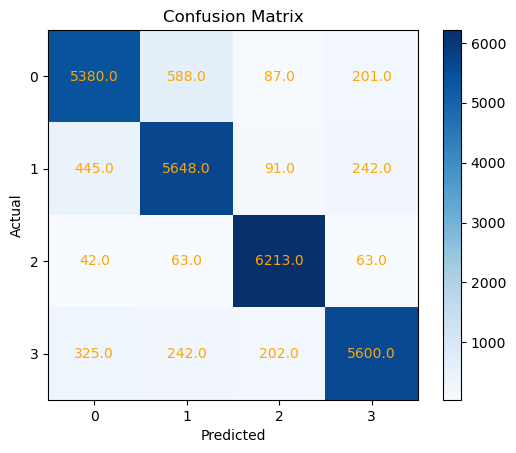

In [29]:
confusion_matrix = metrics.confusionMatrix()
confusion_matrix_np = np.array(confusion_matrix.toArray())
labels = [str(i) for i in range(confusion_matrix.numRows)]

plt.imshow(confusion_matrix_np, cmap = 'Blues')
plt.title("Confusion Matrix")
plt.colorbar()

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, confusion_matrix_np[i, j], ha = 'center', va = 'center', color = 'orange')

plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [42]:
from pyspark.sql.types import *
example1 = [('1', "The Ambassador of Ukraine to Germany showed the Leopard 1A5 tanks promised to Ukraine."),
            ('2', "Interacted with top CEOs during the business roundtable in Sydney. Elaborated on the business opportunities in India and the reform trajectory of our Government. Invited Australian businesses to invest in India."),
            ('3', "People rightly point out that much of San Francisco is clean, but it’s also the case that half of all sidewalks in commercial areas have feces on them, according to a major city-commissioned survey. City-wide, 30% of sidewalks had feces on them."), 
            ('4', "Buying now costs 45% more than renting on a monthly basis And that's BEFORE putting down 20% to buy the house How can the average American afford to buy?")]
schema = StructType([StructField("post_id", StringType(), True)\
                    ,StructField("descriptions", StringType(), True)])
example1 = spark.createDataFrame(data = example1, schema = schema)
example1 = preprocessing(example1.select('descriptions'), 'descriptions')
featurized_example = hashing_tf.transform(example1)
rescaled_example = feature_selector_model.transform(featurized_example) 

In [64]:
pred_example1 = best_model.transform(rescaled_example)
pred_example1.select('descriptions', 'prediction').show()

+--------------------+----------+
|        descriptions|prediction|
+--------------------+----------+
|The Ambassador of...|       3.0|
|Interacted with t...|       0.0|
|People rightly po...|       1.0|
|Buying now costs ...|       0.0|
+--------------------+----------+

